<a href="https://colab.research.google.com/github/Zenith1618/LLM/blob/main/Transfomer_Intuition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
B,T,C = 4,8,2

#B- batch size: how many sentence in each batch
#T- Timestamp: How many token in each sentence
#C- Channel: Dimension or embedding each token will have in vector space

x = torch.randn(B,T,C)

In [3]:
# Now how to convey the meaning of the prefix to the model: One way to go is summation but then we have a problem of scaling of the summation as there would exist a lot a
# lot of parity, For ex. a sentence with 3 words summation would be less than a sentence with 8 words.
# Solution: normalize with no. of words: Average

x_bow = torch.zeros_like(x)     # Bag of words

for b in range(B):
    for t in range(T):
        x_prev = x[b,:t+1]      # slicing the sentence
        x_bow[b,t] = torch.mean(x_prev,axis=0)  # Storing the average

x_bow.shape

torch.Size([4, 8, 2])

In [4]:
# But does it give enough info to the model? We will explore that in a bit

How to make the same code efficient(Efficiency of Average)

In [5]:
b = torch.randint(0,10,(3,2)).float()       # Matrix of range of element from 0 to 10 with dim: 3x2

In [6]:
a = torch.ones((3,3))
c = a @ b   # Matrix Multiplication
print(f"a\n{a}\n--")
print(f"b\n{b}\n--")
print(f"c\n{c}\n--")

a
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
--
b
tensor([[5., 1.],
        [2., 9.],
        [6., 9.]])
--
c
tensor([[13., 19.],
        [13., 19.],
        [13., 19.]])
--


If you would notice something, we are doing summation of matrix b rows but using multiplication or rather matrix multiplication

In [7]:
# The problem here is that we dont need the postfix token to predict the next word, only the prefix: So in order to solve this : Lower triangular matrix
a = torch.tril(torch.ones((3,3)))
c = a@b

print(f"a\n{a}\n--")
print(f"a\n{b}\n--")
print(f"a\n{c}\n--")


a
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
--
a
tensor([[5., 1.],
        [2., 9.],
        [6., 9.]])
--
a
tensor([[ 5.,  1.],
        [ 7., 10.],
        [13., 19.]])
--


If you look at A matrix, the first row has just one '1' meaning only one word would be shown to the model and so on.

In [8]:
a = torch.tril(torch.ones((3,3)))
a = a/torch.sum(a,axis=-1,keepdims=True)    # This is done to normalize the A matrix which will normalize the b matrix sum finally when multiplied
c = a@b

print(f"a\n{a}\n--")
print(f"a\n{b}\n--")
print(f"a\n{c}\n--")


a
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
a
tensor([[5., 1.],
        [2., 9.],
        [6., 9.]])
--
a
tensor([[5.0000, 1.0000],
        [3.5000, 5.0000],
        [4.3333, 6.3333]])
--


In [9]:
# Now we will write the same thing in a fancy way
weights = torch.tril(torch.ones((T,T)))
weights = weights / torch.sum(weights,axis=-1,keepdims=True)
x_bow2 = weights @ x # (T,T) (B,T,C)

torch.allclose(x_bow,x_bow2)        # This compare whether the 2 matrix are same or not
# This is done to check if our efficient approach is working fine or not

True

Another way to do it

Softmax function:  $\sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K$

In [10]:
tril = torch.tril(torch.ones((T,T)))    #lower triangular matrix
weights = torch.zeros((T,T))
weights = weights.masked_fill(tril==0, float("-inf"))   # change weight as -infinity where we have tril(ij) == 0(-inf is used to mask the future tokens)
weights = torch.nn.functional.softmax(weights,dim=-1)
# Now e^(-inf) or 1/e^(inf) = 0
# so wherever we will have -inf it would become zero and rest all would be scaled/averaged down by the funtion
x_bow3 = weights @ x #(T,T) (B,T,C)

torch.allclose(x_bow,x_bow3)

True

Now what if the weights here were not initialized with zero. As when initialized with zero each and every word has equal importance or attention.

Now in order to capture the meaning of the sentence we need to attend to certain parts of word of sentence more than other:- Here comes attention

Instead of like making the matrix of 1 and 0 we can use attention mechanism and then mask the postfix while having attention of the prefix

In [13]:
B,T,C = 4,8,2
head_size=16

x = torch.randn(B,T,C)

# Linear projection of x
# also known as self attentionn
key = torch.nn.Linear(C,head_size,bias=False)
value = torch.nn.Linear(C,head_size,bias=False)
query = torch.nn.Linear(C,head_size,bias=False)

k = key(x) #B,T,16
q = query(x) #B,T,16
v = value(x) #B,T,16

tril = torch.tril(torch.ones((T,T)))
# This line basically doesnt initialize weights with zero, rather it initialize it with query key dot product
weights = q @ k.transpose(-2,-1)
weights = weights.masked_fill(tril==0,float("-inf"))    # Using this we dont let the future token take part in present prediction: Casuality
weights = torch.nn.functional.softmax(weights,dim=-1)
out = weights @ v #(T,T) (B,T,C)

out.shape

torch.Size([4, 8, 16])

Each word can be taken as with 2 similar vector but in different space, one being query and other being key. Now the query vector of 1 word is tried out with every word key to find out the similarity using a dot product similarity method.

Once we have the dot product, that is basically the weights

The reason we make key value and query is to decouple as decoupling makes model learn more easily because if we keep using x all the time we will have very strict transformation.



In [14]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)

wei = q @ k.transpose(-2,-1)

In [15]:
k.var()

tensor(0.9271)

In [16]:
q.var()

tensor(0.9507)

In [17]:
wei.var()

tensor(12.4027)


But here we have a problem. The variance of k and q are around 1 as we have used normal distribution but wei matrix has very big variance and when it go to softmax function it will be peak out and everything else would be around zero which will affect the gradient propagation and thats bad.

Solution

In [18]:
weights = q @ k.transpose(-2,-1) * (head_size ** -0.5)

weights.var()

tensor(0.7752)

Encoder:
*   Self Attention Non Causal: We dont have the masked fill, we rather use the whole thing in representation learning


Decoder:
*   Cross Causal: Query comes from decoder and key value from encoder



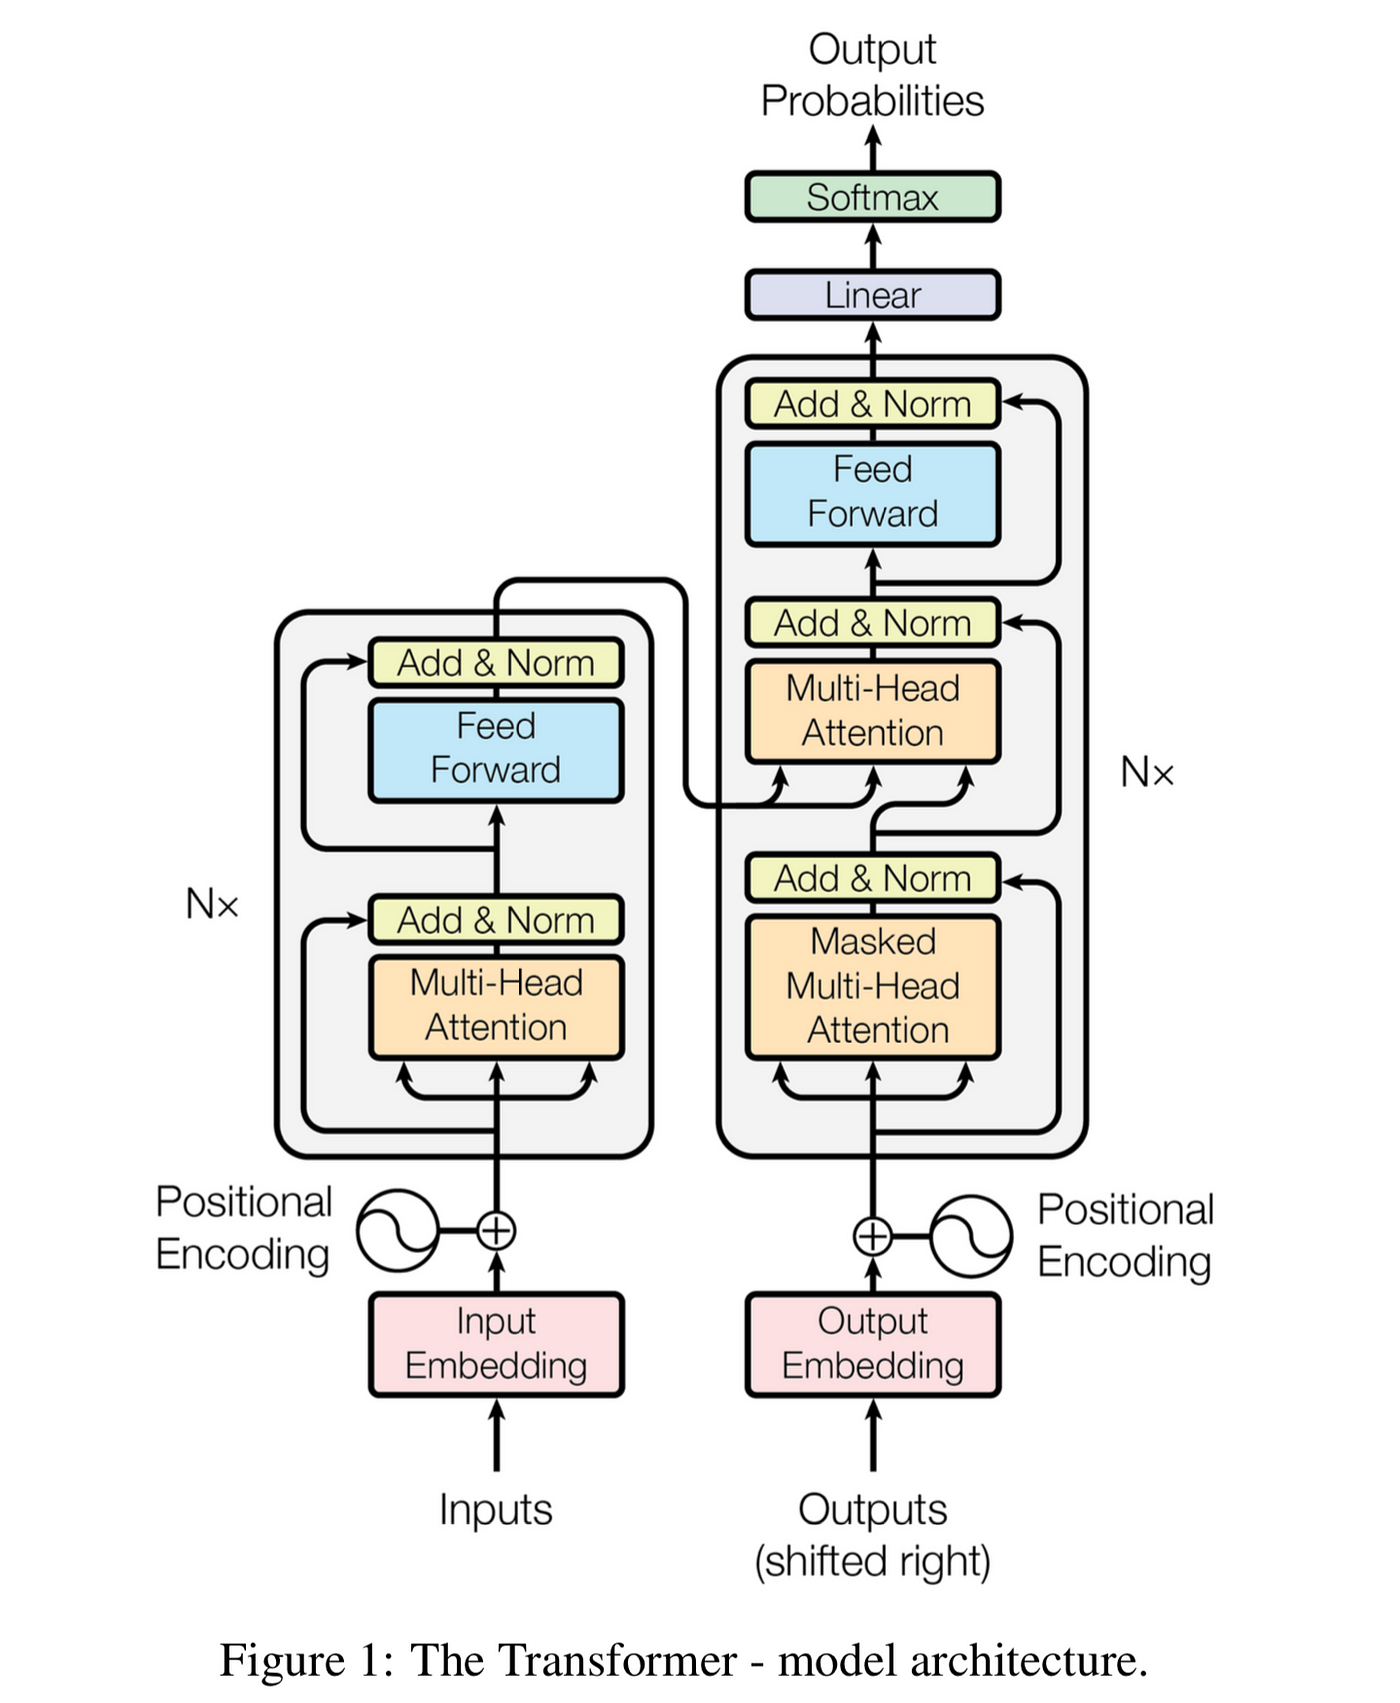

Here we havent talked about the positional encoding. If we change the word order there is no way the model would understand the words have been changed because the weight will remain the same, so here comes positional ecnoding wherein we combine the sin, cosine squiggles with weight to give the position context to the model